In [1]:
#import required libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from optbinning import BinningProcess
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

(CVXPY) Feb 11 02:53:02 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 11 02:53:02 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
#load in data
data = pd.read_csv("rolling_average_differentials.csv")

#randomly sample an outcome from each game
data = data.groupby("game_id").sample(n=1, random_state=84)

#filter for only stats variables and the target variable
data = data.iloc[:, 4:]
data.head()

,scores,passing_yards,rushing_yards,passing_touchdown,rushing_touchdown,highest_yac,time_to_throw,sacks_taken,fourth_down_converted,third_down_converted,...,wpa,qb_hits,tackles_for_loss,punts_inside_20,punt_attempts,punts_blocked,return_yards,drives,longest_drive,win
1,0.8,66.2,-59.2,1.4,-0.4,4.0,0.163798,-1.8,0.4,-0.4,...,-0.183276,1.0,1.8,-0.6,-1.6,0.2,0.6,-1.6,0.4,0
2,-4.0,-25.0,34.2,-1.2,0.8,-2.2,-0.220806,-0.8,-0.4,0.2,...,0.219131,-2.8,-0.6,0.8,0.2,0.0,4.4,1.2,-2.2,1
4,15.6,-17.2,131.0,1.0,1.2,-7.0,0.230001,-1.0,1.0,0.4,...,0.226656,-1.6,-0.4,0.4,-2.0,0.0,-8.6,-0.4,1.2,1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [5]:
#separate target and feature variables
colnames = list(data.columns[:-1])
X = data[colnames]
y = data["win"]

#bin the feature variables
bin_proc = BinningProcess(colnames)
bin_fit = bin_proc.fit(X, y).summary()

#replace original variables with binned values
X_binned = bin_proc.transform(X, metric="indices")
data[colnames] = X_binned  
data.head()

,scores,passing_yards,rushing_yards,passing_touchdown,rushing_touchdown,highest_yac,time_to_throw,sacks_taken,fourth_down_converted,third_down_converted,...,wpa,qb_hits,tackles_for_loss,punts_inside_20,punt_attempts,punts_blocked,return_yards,drives,longest_drive,win
1,5,5,0,5,3,3,2,0,5,4,...,2,4,3,1,1,2,2,2,5,0
2,4,2,2,0,6,2,1,2,3,5,...,5,0,1,3,4,1,2,2,0,1
4,9,2,3,4,7,2,3,2,6,5,...,5,1,1,2,1,1,1,2,5,1
6,5,3,2,2,3,2,1,4,4,5,...,3,2,1,2,3,1,2,2,4,0
7,5,3,2,2,3,2,1,4,4,5,...,3,2,1,2,3,1,2,2,4,1


In [6]:
#split data into training and testing
train, test = train_test_split(data, test_size=0.20, random_state=84)
train.head()

,scores,passing_yards,rushing_yards,passing_touchdown,rushing_touchdown,highest_yac,time_to_throw,sacks_taken,fourth_down_converted,third_down_converted,...,wpa,qb_hits,tackles_for_loss,punts_inside_20,punt_attempts,punts_blocked,return_yards,drives,longest_drive,win
1391,5,4,1,2,4,4,1,6,1,5,...,3,5,3,0,4,1,0,2,2,0
663,8,6,3,4,6,3,1,1,3,4,...,6,1,1,2,3,1,1,2,5,1
736,9,6,2,5,5,3,1,0,5,1,...,6,0,1,2,0,1,3,0,0,1
184,7,5,3,3,3,4,1,0,3,8,...,6,0,3,2,2,1,0,0,3,0
996,3,4,1,1,3,2,2,5,3,0,...,3,3,1,0,4,1,5,2,3,0


In [9]:
#separate target and feature variables
colnames = list(train.columns[:-1])
X_train = train[colnames]
y_train = train["win"]

#initialize a random forest classifier
rf = RandomForestClassifier(n_estimators=500,
                                  random_state=84,
                                  oob_score=True)

#fit the random forest model and print the out-of-bag score 
rf.fit(X_train, y_train)
rf.oob_score_

0.6030150753768844

In [11]:
#checks for default number of variables to consider at each split
mtry = np.sqrt(len(colnames))
print(mtry, "\n")

#define the hyperparameter grid for random forest tuning
param_grid = {
    'bootstrap': [True],
    'max_features': [3, 4, 5, 6, 7, 8], #mtry
    'n_estimators': [100, 200, 300, 400, 500, 600] #number of trees
}

#initialize a random forest classifier
rf = RandomForestClassifier(random_state=84)

#perform grid search with 10-fold cross-validation to find best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10)


#fit the grid search model and print the best hyperparameters
grid_search.fit(X_train, y_train)
grid_search.best_params_

5.291502622129181 



{'bootstrap': True, 'max_features': 4, 'n_estimators': 200}

In [13]:
#initialize a Random Forest classifier with hyperparameters from grid search
rf = RandomForestClassifier(n_estimators=200,
                           max_features=4,
                           random_state=84,
                           oob_score=True)

#fit the grid search model and print the out-of-bag score
rf.fit(X_train, y_train)
rf.oob_score_

0.5891959798994975

In [15]:
#separate target and feature variables
colnames = list(test.columns[:-1])
X_test = test[colnames]
y_test = test["win"]

#add predicted probabilities for wins to test data
test["p_hat"] = rf.predict_proba(X_test)[:, 1]

#generate the false positive rate, true positive rate, and cutoffs for the roc curve
fpr, tpr, cutoffs = roc_curve(test["win"], test["p_hat"])

#create a dataframe containing the tpr, fpr, cutoffs, and youden's j statistic
data = {"TPR": tpr, "FPR": fpr, "Cut-off": cutoffs, "Youden": tpr-fpr}
youden = pd.DataFrame(data)
youden.sort_values(by="Youden", ascending=False) #highest j statistic is optimal cutoff

,TPR,FPR,Cut-off,Youden
62,0.793478,0.425926,0.486818,0.367552
46,0.619565,0.259259,0.545000,0.360306
44,0.608696,0.250000,0.549256,0.358696
61,0.782609,0.425926,0.490000,0.356683
48,0.630435,0.277778,0.537000,0.352657
...,...,...,...,...
95,0.978261,0.962963,0.210000,0.015298
3,0.032609,0.018519,0.826538,0.014090
1,0.010870,0.000000,0.880000,0.010870
0,0.000000,0.000000,1.880000,0.000000


0.708786231884058 



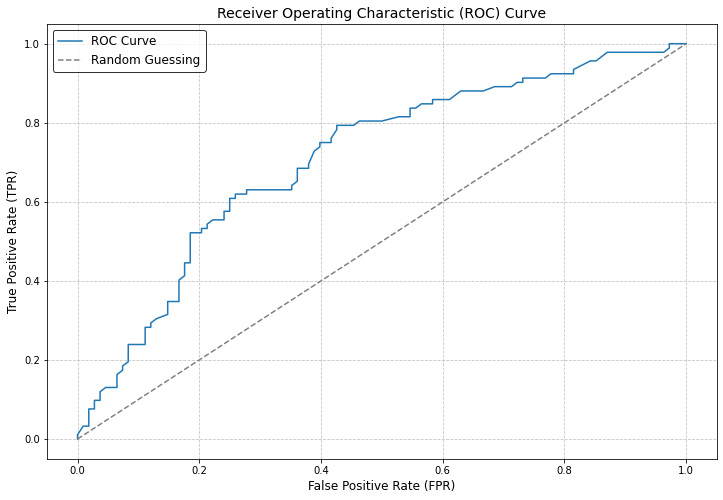

In [17]:
#print the area under the roc curve
print(auc(fpr, tpr), "\n")

#plot the roc curve
fig, ax = plt.subplots(figsize=(12, 8))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot(ax=ax, label="ROC Curve")  
ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
ax.set_title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)
ax.set_xlabel("False Positive Rate (FPR)", fontsize=12)
ax.set_ylabel("True Positive Rate (TPR)", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.75)
ax.legend(loc="upper left", fontsize=12, frameon=True, facecolor="white", edgecolor="black")
plt.show()